✅ Using dataset path: /content/fruits/custom_fruits_ds
✅ Classes found: ['fresh_apple', 'stale_apple']
✅ Train images: 40 | Test images: 10


<ipython-input-2-11818c59d06b>:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Mixed precision training
<ipython-input-2-11818c59d06b>:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



🚀 Training Started...

Epoch [1/10] - Loss: 0.6760, Accuracy: 55.00%
Epoch [2/10] - Loss: 0.3172, Accuracy: 90.00%
Epoch [3/10] - Loss: 0.1192, Accuracy: 97.50%
Epoch [4/10] - Loss: 0.0270, Accuracy: 100.00%
Epoch [5/10] - Loss: 0.1466, Accuracy: 97.50%
Epoch [6/10] - Loss: 0.0146, Accuracy: 100.00%
Epoch [7/10] - Loss: 0.0122, Accuracy: 100.00%
Epoch [8/10] - Loss: 0.0485, Accuracy: 97.50%
Epoch [9/10] - Loss: 0.0102, Accuracy: 100.00%
Epoch [10/10] - Loss: 0.0089, Accuracy: 100.00%

🎉 Training Complete!
✅ Model saved at /content/fruit_swin_model.pth

📊 Test Loss: 0.0248
✅ Test Accuracy: 100.00%
✅ Model loaded successfully!


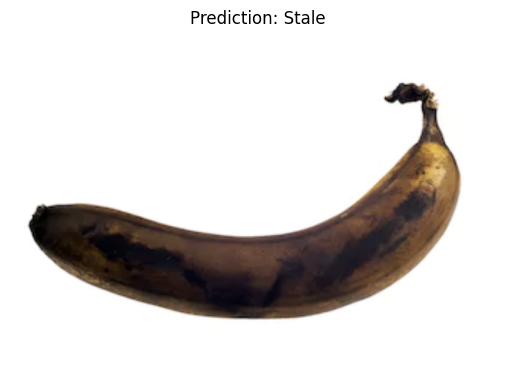

🍏 Predicted: Stale


In [ ]:
import os
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.models import swin_t
from torch.cuda.amp import autocast, GradScaler
from PIL import Image
import matplotlib.pyplot as plt

# 1️⃣ Extract Dataset
zip_path = "/content/custom_fruits_ds.zip"  # Adjust path if needed
dataset_root = "/content/fruits"

if not os.path.exists(dataset_root):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_root)
    print("✅ Dataset extracted successfully!")

# Ensure correct dataset path
subfolders = [f.name for f in os.scandir(dataset_root) if f.is_dir()]
dataset_path = os.path.join(dataset_root, subfolders[0]) if len(subfolders) == 1 else dataset_root

print("✅ Using dataset path:", dataset_path)

# 2️⃣ Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 3️⃣ Load Dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("✅ Classes found:", dataset.classes)
print("✅ Train images:", len(train_dataset), "| Test images:", len(test_dataset))

# 4️⃣ Define Swin Transformer Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2  # Fresh or Stale classification

model = swin_t(weights="IMAGENET1K_V1")
model.head = nn.Linear(model.head.in_features, num_classes)
model = model.to(device)

# 5️⃣ Define Loss, Optimizer & Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
scaler = GradScaler()  # Mixed precision training

# 6️⃣ Train Model
num_epochs = 10
print("\n🚀 Training Started...\n")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

print("\n🎉 Training Complete!")

# 7️⃣ Save Model
model_path = "/content/fruit_swin_model.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved at {model_path}")

# 8️⃣ Evaluate Model
model.eval()
test_loss, correct, total = 0.0, 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f"\n📊 Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.2f}%")

# 9️⃣ Load Model for Prediction
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print("✅ Model loaded successfully!")

# 🔟 Predict Fresh or Stale for a Single Image
def predict_fruit_freshness(image_path):
    # Load and transform image
    image = Image.open(image_path).convert("RGB")
    transformed_image = transform(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = model(transformed_image)
        _, predicted_class = torch.max(output, 1)

    class_names = ["Fresh", "Stale"]
    predicted_label = class_names[predicted_class.item()]

    # Display image
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Prediction: {predicted_label}")
    plt.show()

    return predicted_label

# 🔹 Example Usage
image_path = "/content/stale banana.png"  # Change this to your test image path
if os.path.exists(image_path):
    prediction = predict_fruit_freshness(image_path)
    print(f"🍏 Predicted: {prediction}")
else:
    print("❌ Image file not found!")


In [ ]:
#drive upload dataset swin model

In [ ]:
import os
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.models import swin_t
from torch.cuda.amp import autocast, GradScaler
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive
import shutil

# 1️⃣ Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# 2️⃣ Extract Dataset from Drive
dataset_drive_path = "/content/drive/MyDrive/archive.zip"  # Update path if needed
dataset_root = "/content/fruits"

# Remove old dataset folder
if os.path.exists(dataset_root):
    shutil.rmtree(dataset_root)  # Delete old files
    print("✅ Old dataset removed!")

# Extract new dataset
with zipfile.ZipFile(dataset_drive_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_root)
print("✅ Dataset extracted successfully!")

# Ensure correct dataset path
subfolders = [f.name for f in os.scandir(dataset_root) if f.is_dir()]
dataset_path = os.path.join(dataset_root, subfolders[0]) if len(subfolders) == 1 else dataset_root

print("✅ Using dataset path:", dataset_path)

# 3️⃣ Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 4️⃣ Load Dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
num_classes = len(dataset.classes)  # Dynamically get number of categories
print(f"✅ Number of classes detected: {num_classes}")

from glob import glob
all_images = glob(f"{dataset_root}/**/*.jpg", recursive=True)  # Change extension if needed
print(f"✅ Total images found: {len(all_images)}")

train_size = int(0.8 * len(dataset))  # 80% Training
test_size = len(dataset) - train_size  # 20% Testing
print(f"✅ Expected Train: {train_size}, Test: {test_size}")  # Debugging step

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# 5️⃣ Define Swin Transformer Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = swin_t(weights="IMAGENET1K_V1")
model.head = nn.Linear(model.head.in_features, num_classes)
model = model.to(device)

# 6️⃣ Define Loss, Optimizer & Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
scaler = GradScaler()  # Mixed precision training

# 7️⃣ Train Model
num_epochs = 10
print("\n🚀 Training Started...\n")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

print("\n🎉 Training Complete!")

# 8️⃣ Save Model
model_path = "/content/drive/MyDrive/fruit_swin_model.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved at {model_path}")

# 9️⃣ Evaluate Model
model.eval()
test_loss, correct, total = 0.0, 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f"\n📊 Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.2f}%")

# 🔟 Load Model for Prediction
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print("✅ Model loaded successfully!")

# 🔹 Predict Class for a Single Image
def predict_fruit_category(image_path):
    # Load and transform image
    image = Image.open(image_path).convert("RGB")
    transformed_image = transform(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = model(transformed_image)
        _, predicted_class = torch.max(output, 1)

    class_names = dataset.classes  # Get correct category names
    predicted_label = class_names[predicted_class.item()]

    # Display image
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Prediction: {predicted_label}")
    plt.show()

    return predicted_label


Mounted at /content/drive
✅ Dataset extracted successfully!
✅ Using dataset path: /content/fruits
✅ Number of classes detected: 12
✅ Total images found: 4538
✅ Expected Train: 11745, Test: 2937


Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 148MB/s]
<ipython-input-2-6bb6586e7666>:79: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Mixed precision training
<ipython-input-2-6bb6586e7666>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



🚀 Training Started...

Epoch [1/10] - Loss: 0.2019, Accuracy: 93.78%
Epoch [2/10] - Loss: 0.0751, Accuracy: 97.83%
Epoch [3/10] - Loss: 0.0713, Accuracy: 97.90%
Epoch [4/10] - Loss: 0.0139, Accuracy: 99.60%
Epoch [5/10] - Loss: 0.0166, Accuracy: 99.50%
Epoch [6/10] - Loss: 0.0184, Accuracy: 99.56%
Epoch [7/10] - Loss: 0.0085, Accuracy: 99.74%
Epoch [8/10] - Loss: 0.0060, Accuracy: 99.80%
Epoch [9/10] - Loss: 0.0040, Accuracy: 99.87%
Epoch [10/10] - Loss: 0.0036, Accuracy: 99.86%

🎉 Training Complete!
✅ Model saved at /content/drive/MyDrive/fruit_swin_model.pth

📊 Test Loss: 0.0006
✅ Test Accuracy: 99.97%
✅ Model loaded successfully!
❌ Image file not found!


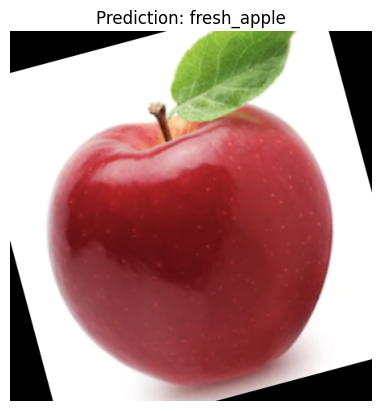

🍏 Predicted: fresh_apple


In [ ]:
# 🔹 Example Usage
image_path = "/content/rotated_by_15_Screen Shot 2018-06-08 at 5.01.08 PM.png"  # Update this path with your test image
if os.path.exists(image_path):
    prediction = predict_fruit_category(image_path)
    print(f"🍏 Predicted: {prediction}")
else:
    print("❌ Image file not found!")